# Session 2: An Introduction to Statistical Learning and Linear Regression 
## Objectives 
By finishing this notebook you must be able to
  + write the likelihood function for any distribution knowing its mass or density function,  
  + maximize the likelihood function by grid search vs using built-in optimization functions, 
  + implement a simple and linear regression problem in Python using both Ordinary Least Scores (OLS) and Maximum Likelihood Estimator (MLE), and  
  + assess the goodness of fit of your regression model; and do predictions using your model.  

 

## Point Estimation


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from random import sample
import seaborn as sns
import scipy.stats as st
import pandas as pd

# The following two lines allow printing multiple outcomes in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Law of large numbers

In [0]:
mu, sigma = 0, 2
n = 10000
s = np.random.normal(mu, sigma, n)
s_partial_mean = [sum(s[:i])/i for i in range(1,len(s)+1)]
s_pos = [i for i in range(1,len(s_partial_mean)+1)]


<font color="red">Exercise </font> <br>
How is the above piece of code related to the *law of large numbers*?


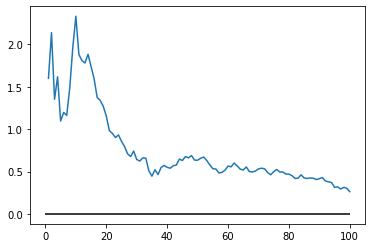

In [0]:
horizon = 100
plt.hlines(y=0,xmin=0,xmax=horizon)
plt.plot(s_pos[0:horizon],s_partial_mean[0:horizon])

### Central Limit Theorem

In [0]:
def simulate_dice_roll(number_of_rolls):
    dice_values = [1, 2, 3, 4, 5, 6]
    return [sample(dice_values,1) for _ in range(number_of_rolls)]

In [0]:
sample([1,2,3,3], 1)

[3]

<font color="red">Exercise </font> <br>
What if one replaces the last line with `return [sample(dice_values,number_of_rolls)]` ?

In [0]:
def multiple_experiments(number_of_roll, number_experiment):
    return [simulate_dice_roll(number_of_roll) for _ in range(number_experiment)]

<font color="red">Exercise </font> <br>
Use `numpy.random.choice` and rewrite the above function.

In [0]:
def calculate_mean_dice_value(multiple_experiments_list):
    return [sum(experiments)/len(experiments) for experiments in multiple_experiments_list]

In [0]:
experiments = multiple_experiments(10,5)
print(experiments)

[[5, 2, 6, 4, 1, 6, 5, 3, 4, 6], [4, 3, 4, 4, 6, 5, 1, 6, 5, 5], [1, 6, 5, 2, 1, 3, 4, 3, 6, 4], [4, 2, 2, 2, 5, 4, 6, 5, 6, 6], [1, 5, 1, 6, 6, 3, 1, 1, 2, 6]]


In [0]:
mean_dice_value = calculate_mean_dice_value(experiments)
mean_dice_value

[4.2, 4.3, 3.5, 4.2, 3.2]

No handles with labels found to put in legend.


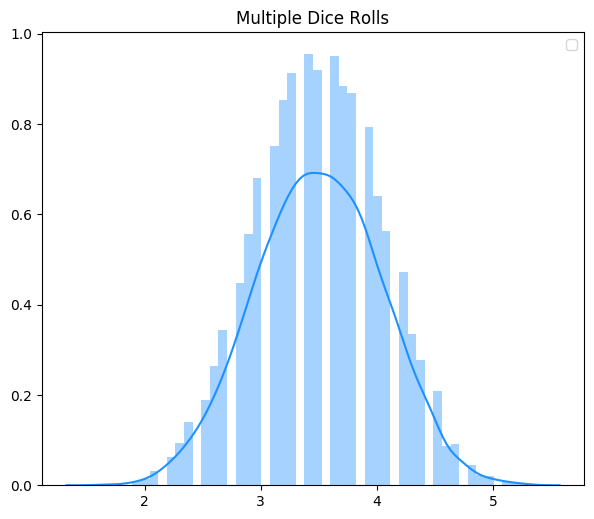

In [0]:
number_throw = 10       # number of rolls
number_experiments = 10000
mean_dice_value = np.array(calculate_mean_dice_value(multiple_experiments(number_throw,number_experiments)))
plt.subplots(figsize=(7,6), dpi=100)
sns.distplot(mean_dice_value, color="dodgerblue")
plt.title('Multiple Dice Rolls')
plt.legend();

## Confidence Intervals

In [0]:
mu, sigma = 1000, 25
n = 100
weekly_incomes = np.random.normal(mu, sigma, n)

In [0]:
# Estimate the mean μ of this population and the standard deviation.
estimated_mean, standard_dev = np.mean(weekly_incomes), np.std(weekly_incomes)

In [0]:
# Find a 95% confidence interval for the mean u.
quantile_95 = st.norm.ppf(.95)            # reverse of CDF
radius = quantile_95 * standard_dev/np.sqrt(n)
lower_bound = estimated_mean - radius
upper_bound = estimated_mean + radius

In [0]:
def confidence_intervals(num_intervals, mean, standard_dev, num_obs):
    estimated_means = []
    marges = []
    quantile_95 = st.norm.ppf(.975)
    for interval in range(num_intervals):
        np.random.seed(interval)
        weekly_incomes = np.random.normal(mean, standard_dev, num_obs)
        estimated_mean, estimated_std = np.mean(weekly_incomes), np.std(weekly_incomes)
        marge = quantile_95 * estimated_std/np.sqrt(num_obs)
        estimated_means.append(estimated_mean)
        marges.append(marge)
    return estimated_means, marges

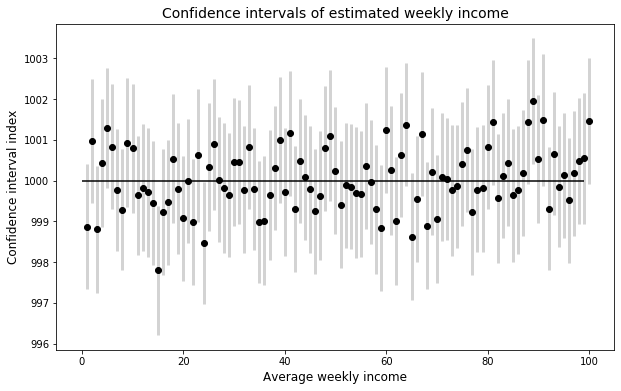

In [0]:
# Draw a plot to visualize the confidence intervals.
estimated_means,marges = confidence_intervals(100, mu, sigma, 1000)
x_pos = [i for i in range(1,len(estimated_means)+1)]

fig, ax = plt.subplots(figsize=(10, 6))
_ = ax.errorbar(x_pos, estimated_means, yerr=marges, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
_ = ax.hlines(y=mu,xmin=0,xmax=len(estimated_means)-1)
_ = ax.set_title('Confidence intervals of estimated weekly income', fontsize=14)
_ = ax.set_xlabel('Average weekly income', fontsize=12)
_ = ax.set_ylabel('Confidence interval index', fontsize=12)

In [0]:
# Calculate the proportion of intervals that catch the population mean
boolean_conf = [1 if estimated_mean - marge < 1000 < estimated_mean + marge else 0 for estimated_mean, marge in zip(estimated_means, marges)]
proportion = sum(boolean_conf)/len(boolean_conf)
print(proportion)

0.97


## Sampling

In [0]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [0]:
# Shuffle observations of the tips dataset.
shuffle_tips = tips.reindex(np.random.permutation(tips.index))
shuffle_tips.head()

,total_bill,tip,sex,smoker,day,time,size
34,17.78,3.27,Male,No,Sat,Dinner,2
102,44.30,2.50,Female,Yes,Sat,Dinner,3
29,19.65,3.00,Female,No,Sat,Dinner,2
110,14.00,3.00,Male,No,Sat,Dinner,2
121,13.42,1.68,Female,No,Thur,Lunch,2


In [0]:
# Sample 10 random observations from tips dataset.
subset_tips = shuffle_tips.head(10)

In [0]:
subset_tips

,total_bill,tip,sex,smoker,day,time,size
34,17.78,3.27,Male,No,Sat,Dinner,2
102,44.30,2.50,Female,Yes,Sat,Dinner,3
29,19.65,3.00,Female,No,Sat,Dinner,2
110,14.00,3.00,Male,No,Sat,Dinner,2
121,13.42,1.68,Female,No,Thur,Lunch,2
136,10.33,2.00,Female,No,Thur,Lunch,2
27,12.69,2.00,Male,No,Sat,Dinner,2
211,25.89,5.16,Male,Yes,Sat,Dinner,4
43,9.68,1.32,Male,No,Sun,Dinner,2
145,8.35,1.50,Female,No,Thur,Lunch,2


<font color="red">Exercise</font> <br>
Why is the chosen subset random?


In [0]:
# Create a mini dataset with an observation for each size
size_modalities = list(set(tips.loc[:,'size']))    # set() here gives the unique values
tips_sizes = [tips[tips['size'] == size_modality] for size_modality in size_modalities] # split based on size
subsets_tips_size = [tips_size.iloc[0:1,:] for tips_size in tips_sizes]
result = pd.concat(subsets_tips_size)

# Step by step illustration:
#tips_sizes      # split based on size
#type(tips_sizes)
#tips_sizes[0]
#tips_sizes[0].iloc[0:1,:]      # each element of subsets_tips_size

In [0]:
result

,total_bill,tip,sex,smoker,day,time,size
67,3.07,1.00,Female,Yes,Sat,Dinner,1
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
4,24.59,3.61,Female,No,Sun,Dinner,4
142,41.19,5.00,Male,No,Thur,Lunch,5
125,29.80,4.20,Female,No,Thur,Lunch,6


## Simple Linear Regression 

In [0]:
# Data 
municipal_assessment = [45.3,55.6,102.5,38.2,63.6,63.6,41.6,31.3,181.4,89.3,54.9,136.4,77.5,111.2,186.1,69.3,32.5,92.3,36.6,87.4,44.0,88.8,58.1,98.0,39.3,58.8,42.2,45.2,117.4,117.3,122.9,29.3,82.0,79.0,64.4,78.0,75.1,86.8,143.5,85.4,86.6]
house_price = [65,60,140,50,60,80,74,79,275,162,36,235,125,112,268,150,45,142,69,100,123,117,160,188,88,103,65,77,188,156,225,58,132,198,90,110,114,149,315,130,135]

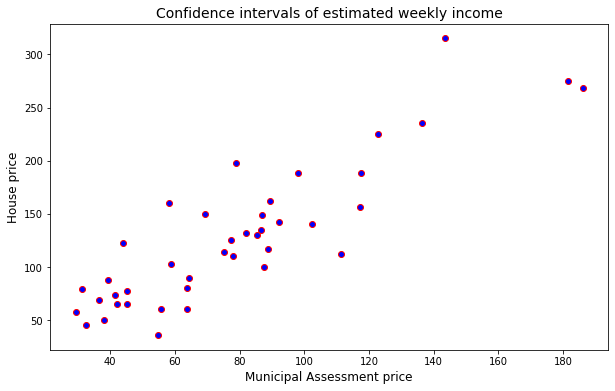

In [0]:
# Draw the scatterplot of the municipal assessment price vs the house price
fig, ax = plt.subplots(figsize=(10, 6))
_ = ax.plot(municipal_assessment , house_price, 'or', mfc='b')
_ = ax.set_title('Confidence intervals of estimated weekly income', fontsize=14)
_ = ax.set_ylabel('House price', fontsize=12)
_ = ax.set_xlabel('Municipal Assessment price', fontsize=12)

In [0]:
# Estimate the intercept and the regressor's coefficient with the least square solution.
y_bar = sum(house_price)/len(house_price)
x_bar = sum(municipal_assessment)/len(municipal_assessment)

a_num = sum([(x_i-x_bar)*(y_i-y_bar) for x_i,y_i in zip(municipal_assessment,house_price)])
a_denom = sum([(x_i-x_bar)**2 for x_i in municipal_assessment])

reg_coef = a_num/a_denom
intercept = y_bar - reg_coef*x_bar

In [0]:
print(reg_coef)
print(intercept)

1.528511701288412
7.258759830176089


In [0]:
a_denom

57823.567804878054

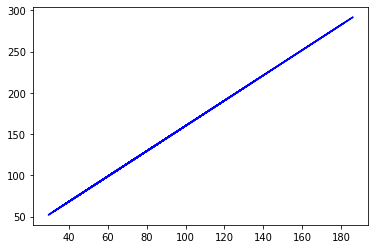

In [0]:
# Plot the simple linear regression line.
plt.plot(np.array(municipal_assessment),intercept +  reg_coef * np.array(municipal_assessment), color='blue')

Text(0.5, 1.0, 'Confidence intervals of estimated weekly income')

Text(0, 0.5, 'House price')

Text(0.5, 0, 'Municipal Assessment price')

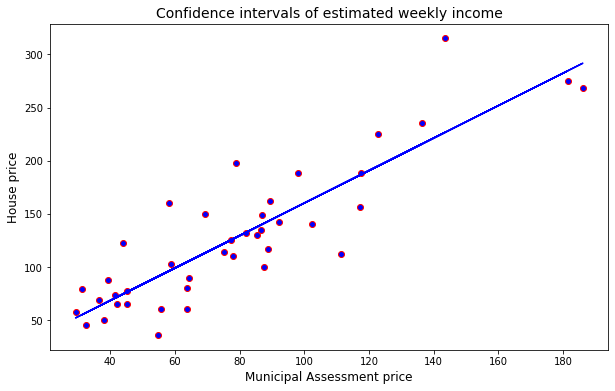

In [0]:
# Draw the scatterplot and the regression equation together.
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(municipal_assessment , house_price, 'or', mfc='b')
ax.plot(np.array(municipal_assessment),intercept +  reg_coef * np.array(municipal_assessment), color='blue')
ax.set_title('Confidence intervals of estimated weekly income', fontsize=14)
ax.set_ylabel('House price', fontsize=12)
ax.set_xlabel('Municipal Assessment price', fontsize=12)

In [0]:
# Fit the model with sklearn package.
from sklearn.linear_model import LinearRegression
d_ = {'house price': house_price, 'municipal assessment': municipal_assessment}
houses_df = pd.DataFrame(data=d_)

lr = LinearRegression() 
lr.fit(X = houses_df[['house price']], y = houses_df[['municipal assessment']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
help(lr.fit)

Help on method fit in module sklearn.linear_model.base:

fit(X, y, sample_weight=None) method of sklearn.linear_model.base.LinearRegression instance
    Fit linear model.
    
    Parameters
    ----------
    X : array-like or sparse matrix, shape (n_samples, n_features)
        Training data
    
    y : array_like, shape (n_samples, n_targets)
        Target values. Will be cast to X's dtype if necessary
    
    sample_weight : numpy array of shape [n_samples]
        Individual weights for each sample
    
        .. versionadded:: 0.17
           parameter *sample_weight* support to LinearRegression.
    
    Returns
    -------
    self : returns an instance of self.



In [0]:
# Returns the R^2 which gives an idea about the goodness of fit:
print(lr.score(X = houses_df[['house price']], y = houses_df[['municipal assessment']]))

0.7673989355313162


In [0]:
# Predict the values associated with our municipal assessment prices
X_new = houses_df[['municipal assessment']].values
predictions_nested = lr.predict(X_new)
predictions = np.array([item for sublist in predictions_nested for item in sublist])
print(predictions)

[ 37.47262658  42.64380651  66.19024717  33.90802682  46.66025694
  46.66025694  35.61501825  30.44383832 105.80248957  59.56310396
  42.2923671   83.20995588  53.63883957  70.55813702 108.1621542
  49.52197788  31.04630588  61.06927287  33.10473673  58.60919698
  36.81995338  59.31207581  43.89894727  63.9309938   34.46028875
  44.25038668  35.91625203  37.42242095  73.6708861   73.62068047
  76.43219578  29.43972571  55.89809294  54.39192403  47.06190199
  53.88986772  52.43390444  58.3079632   86.77455564  57.60508437
  58.20755194]


## Multiple Linear Regression 

In [0]:
from sklearn import linear_model
from sklearn import datasets ## imports datasets from scikit-learn

In [0]:
 ## Loads Boston dataset from datasets library
data = datasets.load_boston()

# Define the data/predictors as the pre-set feature names  
df = pd.DataFrame(data.data, columns=data.feature_names)

# Put the target (housing value -- MEDV) in another DataFrame
target = pd.DataFrame(data.target, columns=["MEDV"])

X = df
y = target['MEDV']

In [0]:
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

In [0]:
predictions = lm.predict(X)
print(predictions[0:5])

[30.00384338 25.02556238 30.56759672 28.60703649 27.94352423]


In [0]:
print(lm.score(X,y))

0.7406426641094094


In [0]:
lm.coef_

array([-1.08011358e-01,  4.64204584e-02,  2.05586264e-02,  2.68673382e+00,
       -1.77666112e+01,  3.80986521e+00,  6.92224640e-04, -1.47556685e+00,
        3.06049479e-01, -1.23345939e-02, -9.52747232e-01,  9.31168327e-03,
       -5.24758378e-01])

In [0]:
lm.intercept_

36.459488385089784